In [314]:
#pip install vaderSentiment

# PROJECT NAME

### PROJECT MEMBERS

In [315]:
#Research Question and Background
#Hypothesis

# Overall question
- Does emotion(postive/negative) influence reaction time
    - fear
- Does isolation affect emotion
- Emotion and memory
    - Happy, sad, fear, sentimental, bored, depression
    - Does music help
    - Does being happy/sad/mad help
    - Enviornment 
        - Loction of learning, learning at school Environment help retain knowledge 
            -Does the emotion in that environment affect it
        - How well can people adapt to forced learning measures
        - 
     - Does body posture affect memory
     - Do drugs imporve memory
         - Does time of consumtion matter
     - 
             
    
- Emotion and music

# Emotions that we want to look at:
- FEAR
- ANGER
- SADNESS
- SENTIMENTAL

# Regions in the brain we want to look at:
- Amygdala
- Temporal lobe
- Prefrontal Cortex
- Hippocampus


# I. Set Up

In [41]:
from lisc import Counts
from lisc.utils.db import SCDB
from lisc.plts.counts import *
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dexplot as dxp

#Data Import
hippDf = pd.read_csv('hippoCorpusV2.csv')
islandersDf = pd.read_csv('Islander_data.csv')

### 1a. Text Mining

In [317]:
#First term list we are searching for
terms_a = [['"fear"'], ['"anger"'], ['"sadness"'], ['"sentimental"']]

# Initialize counts object and use the add_terms method to add terms that we want to search
counts = Counts()
counts.add_terms(terms_a)

# Collect data using the run_collection method
counts.run_collection(verbose=True, db='pubmed', field='tiab')

# Check how many articles were found for each search term
counts.check_counts()

Running counts for:  "fear"
Running counts for:  "anger"
Running counts for:  "sadness"
Running counts for:  "sentimental"
The number of documents found for each search term is:
  '"fear"'          -   76162
  '"anger"'         -   16805
  '"sadness"'       -    6479
  '"sentimental"'   -     236


In [318]:
counts.counts

array([[   0, 2977, 1958,   11],
       [2977,    0, 2427,    4],
       [1958, 2427,    0,    2],
       [  11,    4,    2,    0]])

In [319]:
#Second term list we are searching for
terms_b = [['"amygdala"'], ['"temporal lobe"'], ['"prefrontal cortex"'], ['"hippocampus"']]

# Initialize counts object and use the add_terms method to add terms that we want to search
counts2 = Counts()
counts2.add_terms(terms_b)

# Collect data using the run_collection method
counts2.run_collection(verbose=True, db='pubmed', field='tiab')

# Check how many articles were found for each search term
counts2.check_counts()

Running counts for:  "amygdala"
Running counts for:  "temporal lobe"
Running counts for:  "prefrontal cortex"
Running counts for:  "hippocampus"
The number of documents found for each search term is:
  '"amygdala"'            -    38305
  '"temporal lobe"'       -    34573
  '"prefrontal cortex"'   -    52606
  '"hippocampus"'         -   119693


In [320]:
counts2.counts

array([[    0,  2288,  6604, 11854],
       [ 2288,     0,  1660,  6513],
       [ 6604,  1660,     0,  8873],
       [11854,  6513,  8873,     0]])

In [321]:
#Third term list we are searching for
terms_c = [['"amygdala"'], ['"hippocampus"'],['"fear"'], ['"anger"']]

# Initialize counts object and use the add_terms method to add terms that we want to search
counts3 = Counts()
counts3.add_terms(terms_c)

# Collect data using the run_collection method
counts3.run_collection(verbose=True, db='pubmed', field='tiab')

# Check how many articles were found for each search term
counts3.check_counts()

Running counts for:  "amygdala"
Running counts for:  "hippocampus"
Running counts for:  "fear"
Running counts for:  "anger"
The number of documents found for each search term is:
  '"amygdala"'      -    38305
  '"hippocampus"'   -   119693
  '"fear"'          -    76162
  '"anger"'         -    16805


In [322]:
#Fourth term list we are searching for
terms_d = [['"amygdala"'], ['"prefrontal cortex"'],['"fear"'], ['"attention"']]

# Initialize counts object and use the add_terms method to add terms that we want to search
counts4 = Counts()
counts4.add_terms(terms_d)

# Collect data using the run_collection method
counts4.run_collection(verbose=True, db='pubmed', field='tiab')

# Check how many articles were found for each search term
counts4.check_counts()

Running counts for:  "amygdala"
Running counts for:  "prefrontal cortex"
Running counts for:  "fear"
Running counts for:  "attention"
The number of documents found for each search term is:
  '"amygdala"'            -    38305
  '"prefrontal cortex"'   -    52606
  '"fear"'                -    76162
  '"attention"'           -   479711


In [323]:
counts4.counts

array([[   0, 6604, 5173, 1681],
       [6604,    0, 2100, 5092],
       [5173, 2100,    0, 3870],
       [1681, 5092, 3870,    0]])

# II. Data Cleaning


Going to focus on these columns and check for null values:
- annotatorAge: Lower limit of the age bucket of the worker.
  Buckets are: 18-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54,55+
  
- story: Story about the imagined or recalled event (15-25     sentences)
- distracted: How distracted were you while writing your story? (5-point Likert)

- draining: How taxing/draining was writing for you emotionally? (5-point Likert)

- frequency: How often do you think about or talk about this event? (5-point Likert)

- importance: How impactful, important, or personal is this story/event to you? (5-point Likert)

- logTimeSinceEvent: Log of time (days) since the recalled event happened

- mainEvent: Short phrase describing the main event described

- similarity: How similar to your life does this event/story feel to you? (5-point Likert)

- stressful: How stressful was this writing task? (5-point Likert)

- summary: Summary of the events in the story (1-3 sentences)

- timeSinceEvent: Time (number of days) since the recalled event happened

In [42]:
#Check for null values, if null value found returns True
print('AnnotatorAge null values ... ',hippDf['annotatorAge'].isnull().values.any())
print('Story null values ...        ',hippDf['story'].isnull().values.any())
print('Distracted null values ...   ', hippDf['distracted'].isnull().values.any())
print('Draining null values ...     ', hippDf['draining'].isnull().values.any())
print('Frequency null values ...    ', hippDf['frequency'].isnull().values.any())
print('Importance null values ...   ', hippDf['importance'].isnull().values.any())
print('LTSinceEvent null values ... ', hippDf['logTimeSinceEvent'].isnull().values.any())
print('Similarity null values ...   ', hippDf['similarity'].isnull().values.any())
print('Stressful null values ...    ', hippDf['stressful'].isnull().values.any())
print('TimeSinceEvent null values ..', hippDf['timeSinceEvent'].isnull().values.any())


AnnotatorAge null values ...  True
Story null values ...         False
Distracted null values ...    False
Draining null values ...      False
Frequency null values ...     True
Importance null values ...    True
LTSinceEvent null values ...  False
Similarity null values ...    True
Stressful null values ...     False
TimeSinceEvent null values .. False


As we can see there are some null values so lets remove all those rows that contain a null value in these columns. However ordinal valued columns are the ones we need to insure have no NaN values. So we will remove rows that contain NaN values from the AnnotatorAge column. Later on we will look into the NaN values for frequency and importance as these varry based on their groups

In [19]:
noNaNHippDf = hippDf.dropna(subset=['annotatorAge'])


In [20]:
noNaNHippDf['annotatorAge'].unique()

array([25., 35., 30., 18., 50., 40., 45., 55.])


From this, we can see that there are 8 unique age variables. For this project, we will classify the age bucket 18 and 25 as 'Youth', 30,35,40 as 'Adults', and 45,50,55 as 'Seniors' into a new column called "AgeGroup"

In [21]:
#Categorizes annotatorAge into different age groups
def ageGroup(row):
    if row['annotatorAge'] == 18 or row['annotatorAge'] == 25:
        return 'Youth'
    elif row['annotatorAge'] == 30 or row['annotatorAge'] == 35 or row['annotatorAge'] == 40:
        return 'Adult'
    elif row['annotatorAge'] == 45 or row['annotatorAge'] == 50 or row['annotatorAge'] == 55:
        return 'Senior'
    else:
        return None

In [22]:
ageKey = noNaNHippDf.apply(lambda row: ageGroup(row),axis=1)
ageKey

0        Youth
1        Youth
2        Adult
3        Adult
4        Youth
         ...  
6849     Adult
6850     Youth
6851     Adult
6852     Adult
6853    Senior
Length: 6831, dtype: object

In [23]:
noNaNHippDf['AgeGroup'] = ageKey


/var/folders/wr/0q2rvryx0jn018lpjc485t9m0000gn/T/ipykernel_83461/2312913534.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noNaNHippDf['AgeGroup'] = ageKey


In [24]:
noNaNHippDf['AgeGroup'].unique()

array(['Youth', 'Adult', 'Senior'], dtype=object)

## Splitting data by group
Splitting the data with the memType column with "recalled","imagined", and "retold"

In [25]:
recalled_df = noNaNHippDf[noNaNHippDf['memType']=="recalled"]
imagined_df = noNaNHippDf[noNaNHippDf['memType']=="imagined"]
retold_df = noNaNHippDf[noNaNHippDf['memType']=="retold"]


Going to focus on these columns:
- annotatorAge: Lower limit of the age bucket of the worker.
  Buckets are: 18-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54,55+
  
- story: Story about the imagined or recalled event (15-25     sentences)
- distracted: How distracted were you while writing your story? (5-point Likert)

- draining: How taxing/draining was writing for you emotionally? (5-point Likert)

- frequency: How often do you think about or talk about this event? (5-point Likert)

- importance: How impactful, important, or personal is this story/event to you? (5-point Likert)

- logTimeSinceEvent: Log of time (days) since the recalled event happened

- mainEvent: Short phrase describing the main event described

- similarity: How similar to your life does this event/story feel to you? (5-point Likert)

- stressful: How stressful was this writing task? (5-point Likert)

- summary: Summary of the events in the story (1-3 sentences)

- timeSinceEvent: Time (number of days) since the recalled event happened

- recAgnPairId: ID of the recalled story that corresponds to this retold story (null for imagined stories). Group on   this variable to get the recalled-retold pairs.


In [26]:
newRecalled = recalled_df[['annotatorAge','story','distracted','draining','frequency',
                                         'importance','logTimeSinceEvent','mainEvent','similarity',
                                         'stressful','summary','timeSinceEvent','AgeGroup','recAgnPairId']]
newImagined = imagined_df[['annotatorAge','story','distracted','draining','frequency',
                                         'importance','logTimeSinceEvent','mainEvent','similarity',
                                         'stressful','summary','timeSinceEvent','AgeGroup','recAgnPairId']]
newRetold = retold_df[['annotatorAge','story','distracted','draining','frequency',
                                         'importance','logTimeSinceEvent','mainEvent','similarity',
                                         'stressful','summary','timeSinceEvent','AgeGroup','recAgnPairId']]

# Dropped all null values in case it could affect our analysis
NEEDS TO BE CHECKED


### We are going to make a new table for the recalled and retold groups so that we can more easily apply the spacy package to it

Need to find the unique id's that link the two data sections together

In [44]:
idTags = hippDf['recAgnPairId'].unique()
#Need to remove the null tag
indexOfNull = 0
newIdTags = np.delete(idTags,indexOfNull)
newIdTags

array(['304SM51WA4QG34IRAVFYVE1S8XNSBV', '304SM51WA4QG34IRAVFYVE1SAOBSB3',
       '308Q0PEVB9Z8LX0Y7Z7O060F6NK9IJ', ...,
       '3ZV9H2YQQET47QVNF7ATAK61QT9W3C', '3ZV9H2YQQET47QVNF7ATAK61TBE3WR',
       '3ZY8KE4ISKPJZ21KN8HT1QGYU5NQVO'], dtype=object)

Now that we have all the unique tags we need to find the recalled data and merge it with the retold data

In [45]:
listOfLists = []
secondKeyStory = []
deltaOfTime = []
for tagNumber in range(len(newIdTags)):
    #Get df of unique tag
    tagIds = hippDf[hippDf['recAgnPairId'] == newIdTags[tagNumber]]
    #Grab the first one and add it to the list
    mainVal = tagIds.iloc[0]
    #Take the story of the second
    secondStory = tagIds['story'].iloc[1]
    #Check that the data works right
    timeSinceRe = tagIds['timeSinceEvent'].iloc[1]
    
    
    #Add them to a list to make a DF out of
    listOfLists.append(mainVal)
    secondKeyStory.append(secondStory)
    deltaOfTime.append(timeSinceRe)
    
    
    

In [46]:
didItWork = pd.DataFrame(listOfLists)
didItWork

,AssignmentId,WorkTimeInSeconds,WorkerId,annotatorAge,annotatorGender,annotatorRace,distracted,draining,frequency,importance,...,mostSurprising,openness,recAgnPairId,recImgPairId,similarity,similarityReason,story,stressful,summary,timeSinceEvent
9,3YGXWBAF713GBO8MYUFB8VR53RKC4M,7228,4MFUAYFX,25.0,man,hisp,1.0,1.0,2.0,2.0,...,one giraffe made eye contact with me and got c...,0.625,304SM51WA4QG34IRAVFYVE1S8XNSBV,NaN,NaN,NaN,Me and my girlfriend had gone to the Los Angel...,1.0,Me and my girlfriend went to the zoo on a hot ...,210.0
12,35LDD5557BQEYC9GWBW5I8LCG5AKMA,4925,HE3SATVD,30.0,man,black,3.0,4.0,3.0,3.0,...,me going to the wedding,0.250,304SM51WA4QG34IRAVFYVE1SAOBSB3,NaN,NaN,NaN,My Cousin's WeddingWe went to my cousin’s wedd...,4.0,My life was endangered for doing research on p...,180.0
18,3NAPMVF0ZX10WTY33ZOCZU2SUYL72I,6488,AXJ0SHSA,30.0,man,white,4.0,4.0,4.0,4.0,...,the charges against my friend,-0.125,308Q0PEVB9Z8LX0Y7Z7O060F6NK9IJ,NaN,NaN,NaN,I remember the event like it was just yesterda...,3.0,There was an arrest. I bailed out my friend. I...,60.0
21,3C8HJ7UOP8G9N782WCZF5N9PKNHZMN,1405,2WT572QN,30.0,woman,hisp,1.0,1.0,4.0,4.0,...,he was in a lot of pain waking up,-0.250,308Q0PEVB9Z8LX0Y7Z7O060FETEI96,NaN,NaN,NaN,"When my now four year old son was born, we wer...",1.0,My four year old son needed foot surgery. My h...,60.0
26,3OJSZ2ATDTISVQHQLIQAX154MTN576,612,3MFQXXSF,30.0,man,white,1.0,1.0,5.0,5.0,...,finding out that the baby is a girl.,1.000,308XBLVESJQ42PIEV6FT54WWN37BRA,NaN,NaN,NaN,About seven and a half months ago I found out ...,1.0,I found out I am going to be a father. My wif...,240.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,3WJEQKOXA9OBQAE5RY0I42UEQGAA1D,458,ZWDAU737,30.0,woman,white,1.0,4.0,4.0,5.0,...,that I wasn't always right in my assumptions.,0.625,3ZSANO2JCGT6GLU7FX1UE4SDOZWFSQ,NaN,NaN,NaN,This story is about how a relationship can fal...,2.0,A short story about insight to our own flaws i...,150.0
6693,3ZY8KE4ISKPJZ21KN8HT1QGY6YMVQQ,1999,7FITX0BD,30.0,woman,white,1.0,1.0,2.0,2.0,...,the bear showed up in the neighborhood,0.625,3ZSANO2JCGT6GLU7FX1UE4SDPM3SFL,NaN,NaN,NaN,"As it's mentioned here in the HIT window, the ...",1.0,I was on my way home from the grocery store wh...,180.0
6702,3I7DHKZYGOM5AJWW31OMLTIMZYW5FF,1081,D6RO3AVG,50.0,woman,white,1.0,1.0,3.0,5.0,...,The contractor asked us to give back a discount,-0.125,3ZV9H2YQQET47QVNF7ATAK61QT9W3C,NaN,NaN,NaN,This is really an unbelievable story that caus...,1.0,A discount was given. After the work was done ...,240.0
6710,3MX2NQ3YCAGMA5NH3VU8R0ISQ8D5XM,6008,Y2ZTYC67,40.0,man,white,1.0,1.0,4.0,5.0,...,that in the end she wanted to go back to schoo...,0.375,3ZV9H2YQQET47QVNF7ATAK61TBE3WR,NaN,NaN,NaN,After our oldest came from her first day we pl...,1.0,My oldest daughters first day of kindergarten....,60.0


In [47]:
didItWork['retold stories'] = secondKeyStory
didItWork['time since recalled'] = deltaOfTime

In [48]:
didItWork

,AssignmentId,WorkTimeInSeconds,WorkerId,annotatorAge,annotatorGender,annotatorRace,distracted,draining,frequency,importance,...,recAgnPairId,recImgPairId,similarity,similarityReason,story,stressful,summary,timeSinceEvent,retold stories,time since recalled
9,3YGXWBAF713GBO8MYUFB8VR53RKC4M,7228,4MFUAYFX,25.0,man,hisp,1.0,1.0,2.0,2.0,...,304SM51WA4QG34IRAVFYVE1S8XNSBV,NaN,NaN,NaN,Me and my girlfriend had gone to the Los Angel...,1.0,Me and my girlfriend went to the zoo on a hot ...,210.0,About a month ago me and my girlfriend went to...,3.000000e+01
12,35LDD5557BQEYC9GWBW5I8LCG5AKMA,4925,HE3SATVD,30.0,man,black,3.0,4.0,3.0,3.0,...,304SM51WA4QG34IRAVFYVE1SAOBSB3,NaN,NaN,NaN,My Cousin's WeddingWe went to my cousin’s wedd...,4.0,My life was endangered for doing research on p...,180.0,It happen 2 weeks ago at the library. Stared o...,1.400000e+01
18,3NAPMVF0ZX10WTY33ZOCZU2SUYL72I,6488,AXJ0SHSA,30.0,man,white,4.0,4.0,4.0,4.0,...,308Q0PEVB9Z8LX0Y7Z7O060F6NK9IJ,NaN,NaN,NaN,I remember the event like it was just yesterda...,3.0,There was an arrest. I bailed out my friend. I...,60.0,About a week ago a received a phone call from ...,7.000000e+00
21,3C8HJ7UOP8G9N782WCZF5N9PKNHZMN,1405,2WT572QN,30.0,woman,hisp,1.0,1.0,4.0,4.0,...,308Q0PEVB9Z8LX0Y7Z7O060FETEI96,NaN,NaN,NaN,"When my now four year old son was born, we wer...",1.0,My four year old son needed foot surgery. My h...,60.0,A memorable event that I have recently had hap...,7.000000e+00
26,3OJSZ2ATDTISVQHQLIQAX154MTN576,612,3MFQXXSF,30.0,man,white,1.0,1.0,5.0,5.0,...,308XBLVESJQ42PIEV6FT54WWN37BRA,NaN,NaN,NaN,About seven and a half months ago I found out ...,1.0,I found out I am going to be a father. My wif...,240.0,The biggest thing to happen to me is finding o...,6.666667e+29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,3WJEQKOXA9OBQAE5RY0I42UEQGAA1D,458,ZWDAU737,30.0,woman,white,1.0,4.0,4.0,5.0,...,3ZSANO2JCGT6GLU7FX1UE4SDOZWFSQ,NaN,NaN,NaN,This story is about how a relationship can fal...,2.0,A short story about insight to our own flaws i...,150.0,"Today, I ended up talking with my ex again. We...",3.333333e+06
6693,3ZY8KE4ISKPJZ21KN8HT1QGY6YMVQQ,1999,7FITX0BD,30.0,woman,white,1.0,1.0,2.0,2.0,...,3ZSANO2JCGT6GLU7FX1UE4SDPM3SFL,NaN,NaN,NaN,"As it's mentioned here in the HIT window, the ...",1.0,I was on my way home from the grocery store wh...,180.0,I was coming home from the grocery store a cou...,6.000000e+01
6702,3I7DHKZYGOM5AJWW31OMLTIMZYW5FF,1081,D6RO3AVG,50.0,woman,white,1.0,1.0,3.0,5.0,...,3ZV9H2YQQET47QVNF7ATAK61QT9W3C,NaN,NaN,NaN,This is really an unbelievable story that caus...,1.0,A discount was given. After the work was done ...,240.0,About 8 weeks ago we opted to get a new air co...,2.100000e+01
6710,3MX2NQ3YCAGMA5NH3VU8R0ISQ8D5XM,6008,Y2ZTYC67,40.0,man,white,1.0,1.0,4.0,5.0,...,3ZV9H2YQQET47QVNF7ATAK61TBE3WR,NaN,NaN,NaN,After our oldest came from her first day we pl...,1.0,My oldest daughters first day of kindergarten....,60.0,An incredible day that I still can't believe h...,7.000000e+00


# III. Exploratory Data Analysis

### This is the method that will be used to calculate the sentiment score

In [16]:
def sentScore(dataFrame):
    s_score = []
    s_rating = []
    sentiment_obj = SentimentIntensityAnalyzer()
    for i in range(len(dataFrame)):
        s_score.append(sentiment_obj.polarity_scores(dataFrame.iloc[i,1]))
        comp_score = s_score[i]['compound']
        if comp_score > 0.05:
            s_rating.append("Positive")
        elif comp_score <= -0.05:
            s_rating.append("Negative")
        else:
            s_rating.append("Neutral")
    return [s_score, s_rating]

### IIIa. Sentiment Analysis For Recalled

In [14]:
newRecalled.head()

,annotatorAge,story,distracted,draining,frequency,importance,logTimeSinceEvent,mainEvent,similarity,stressful,summary,timeSinceEvent,AgeGroup
1,25.0,"The day started perfectly, with a great drive ...",1.0,1.0,3.0,4.0,4.499810,a concert.,NaN,1.0,My boyfriend and I went to a concert together ...,90.0,Youth
3,30.0,"Five months ago, my niece and nephew were born...",1.0,4.0,3.0,5.0,5.010635,meeting my twin niece and nephew.,NaN,2.0,My sister gave birth to my twin niece and neph...,150.0,Adult
5,35.0,Burning Man metamorphoses was perfect. I am de...,1.0,1.0,5.0,5.0,3.401197,about my journey this year to Burning Man meta...,NaN,1.0,It is always a journey for me to go to burning...,30.0,Adult
7,18.0,"Dear Diary,I would say this happened about 3 m...",1.0,4.0,5.0,5.0,4.499810,a bad driving experience on the way to Acadia ...,NaN,1.0,What happened is that I was on a trip with my ...,90.0,Youth
10,25.0,About a month ago me and my girlfriend went to...,1.0,1.0,2.0,3.0,3.401197,a trip to the zoo.,NaN,1.0,Me and my girlfriend went to the zoo on a hot ...,30.0,Youth


In [17]:
recalledSentValues = sentScore(newRecalled)

In [18]:
newRecalled['sentiment_score'] = recalledSentValues[0]
newRecalled['sentiment'] = recalledSentValues[1]


/var/folders/wr/0q2rvryx0jn018lpjc485t9m0000gn/T/ipykernel_80751/1647381943.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newRecalled['sentiment_score'] = recalledSentValues[0]
/var/folders/wr/0q2rvryx0jn018lpjc485t9m0000gn/T/ipykernel_80751/1647381943.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newRecalled['sentiment'] = recalledSentValues[1]


In [337]:
newRecalled.head()

,annotatorAge,story,distracted,draining,frequency,importance,logTimeSinceEvent,mainEvent,similarity,stressful,summary,timeSinceEvent,AgeGroup,sentiment_score,sentiment
1,25.0,"The day started perfectly, with a great drive ...",1.0,1.0,3.0,4.0,4.499810,a concert.,NaN,1.0,My boyfriend and I went to a concert together ...,90.0,Youth,"{'neg': 0.03, 'neu': 0.704, 'pos': 0.266, 'com...",Positive
3,30.0,"Five months ago, my niece and nephew were born...",1.0,4.0,3.0,5.0,5.010635,meeting my twin niece and nephew.,NaN,2.0,My sister gave birth to my twin niece and neph...,150.0,Adult,"{'neg': 0.041, 'neu': 0.794, 'pos': 0.165, 'co...",Positive
5,35.0,Burning Man metamorphoses was perfect. I am de...,1.0,1.0,5.0,5.0,3.401197,about my journey this year to Burning Man meta...,NaN,1.0,It is always a journey for me to go to burning...,30.0,Adult,"{'neg': 0.053, 'neu': 0.825, 'pos': 0.122, 'co...",Positive
7,18.0,"Dear Diary,I would say this happened about 3 m...",1.0,4.0,5.0,5.0,4.499810,a bad driving experience on the way to Acadia ...,NaN,1.0,What happened is that I was on a trip with my ...,90.0,Youth,"{'neg': 0.065, 'neu': 0.856, 'pos': 0.079, 'co...",Positive
10,25.0,About a month ago me and my girlfriend went to...,1.0,1.0,2.0,3.0,3.401197,a trip to the zoo.,NaN,1.0,Me and my girlfriend went to the zoo on a hot ...,30.0,Youth,"{'neg': 0.009, 'neu': 0.883, 'pos': 0.108, 'co...",Positive


### IIIb. Sentiment Analysis For Imagined

In [19]:
newImagined.head()

,annotatorAge,story,distracted,draining,frequency,importance,logTimeSinceEvent,mainEvent,similarity,stressful,summary,timeSinceEvent,AgeGroup
0,25.0,"Concerts are my most favorite thing, and my bo...",1.0,1.0,NaN,3.0,4.499810,attending a show,3.0,1.0,My boyfriend and I went to a concert together ...,90.0,Youth
2,35.0,It seems just like yesterday but today makes f...,1.0,1.0,NaN,4.0,5.010635,my sister having her twins a little early,3.0,1.0,My sister gave birth to my twin niece and neph...,150.0,Adult
4,25.0,About a month ago I went to burning man. I was...,2.0,2.0,NaN,3.0,3.401197,the consequences of going to burning man,4.0,4.0,It is always a journey for me to go to burning...,30.0,Youth
6,35.0,"Play stupid games, win stupid prizes road trip...",3.0,1.0,NaN,4.0,4.499810,a scary car ride where we swerved on our way t...,1.0,2.0,What happened is that I was on a trip with my ...,90.0,Adult
8,25.0,I wanted to write about one of the best days i...,1.0,1.0,NaN,4.0,3.401197,my girlfriend and I going to the zoo.,4.0,1.0,Me and my girlfriend went to the zoo on a hot ...,30.0,Youth


In [20]:
imaginedSentValues = sentScore(newImagined)
newImagined['sentiment_score'] = imaginedSentValues[0]
newImagined['sentiment'] = imaginedSentValues[1]
newImagined.head()

/var/folders/wr/0q2rvryx0jn018lpjc485t9m0000gn/T/ipykernel_80751/228504564.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newImagined['sentiment_score'] = imaginedSentValues[0]
/var/folders/wr/0q2rvryx0jn018lpjc485t9m0000gn/T/ipykernel_80751/228504564.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newImagined['sentiment'] = imaginedSentValues[1]


,annotatorAge,story,distracted,draining,frequency,importance,logTimeSinceEvent,mainEvent,similarity,stressful,summary,timeSinceEvent,AgeGroup,sentiment_score,sentiment
0,25.0,"Concerts are my most favorite thing, and my bo...",1.0,1.0,NaN,3.0,4.499810,attending a show,3.0,1.0,My boyfriend and I went to a concert together ...,90.0,Youth,"{'neg': 0.011, 'neu': 0.714, 'pos': 0.274, 'co...",Positive
2,35.0,It seems just like yesterday but today makes f...,1.0,1.0,NaN,4.0,5.010635,my sister having her twins a little early,3.0,1.0,My sister gave birth to my twin niece and neph...,150.0,Adult,"{'neg': 0.023, 'neu': 0.826, 'pos': 0.151, 'co...",Positive
4,25.0,About a month ago I went to burning man. I was...,2.0,2.0,NaN,3.0,3.401197,the consequences of going to burning man,4.0,4.0,It is always a journey for me to go to burning...,30.0,Youth,"{'neg': 0.052, 'neu': 0.872, 'pos': 0.076, 'co...",Positive
6,35.0,"Play stupid games, win stupid prizes road trip...",3.0,1.0,NaN,4.0,4.499810,a scary car ride where we swerved on our way t...,1.0,2.0,What happened is that I was on a trip with my ...,90.0,Adult,"{'neg': 0.099, 'neu': 0.828, 'pos': 0.073, 'co...",Negative
8,25.0,I wanted to write about one of the best days i...,1.0,1.0,NaN,4.0,3.401197,my girlfriend and I going to the zoo.,4.0,1.0,Me and my girlfriend went to the zoo on a hot ...,30.0,Youth,"{'neg': 0.008, 'neu': 0.841, 'pos': 0.151, 'co...",Positive


### IIIc. Sentiment Analysis For Retold

In [340]:
newRetold

,annotatorAge,story,distracted,draining,frequency,importance,logTimeSinceEvent,mainEvent,similarity,stressful,summary,timeSinceEvent,AgeGroup
9,25.0,Me and my girlfriend had gone to the Los Angel...,1.0,1.0,2.0,2.0,5.347108,a trip to the Los Angeles zoo with my girlfriend.,NaN,1.0,Me and my girlfriend went to the zoo on a hot ...,210.0,Youth
12,30.0,My Cousin's WeddingWe went to my cousin’s wedd...,3.0,4.0,3.0,3.0,5.192957,my cousin's wedding,NaN,4.0,My life was endangered for doing research on p...,180.0,Adult
18,30.0,I remember the event like it was just yesterda...,4.0,4.0,4.0,4.0,4.094345,my friend's arrest,NaN,3.0,There was an arrest. I bailed out my friend. I...,60.0,Adult
21,30.0,"When my now four year old son was born, we wer...",1.0,1.0,4.0,4.0,4.094345,my son's foot surgery,NaN,1.0,My four year old son needed foot surgery. My h...,60.0,Adult
26,30.0,About seven and a half months ago I found out ...,1.0,1.0,5.0,5.0,5.480639,Finding out I am going to be a father.,NaN,1.0,I found out I am going to be a father. My wif...,240.0,Adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6725,55.0,Another of my little birds have left the nest....,1.0,2.0,4.0,4.0,4.094345,training my coworker to her new store manager ...,NaN,1.0,My trainee was finally promoted to manager aft...,60.0,Senior
6726,25.0,Earlier this year there was a domestic violenc...,1.0,5.0,5.0,5.0,5.598422,me being involved in a domestic violence incident,NaN,4.0,"Got in a verbal argument with wife, which led ...",270.0,Youth
6727,25.0,I remember a time when i was going to my mothe...,3.0,4.0,4.0,3.0,2.639057,brother getting engaged,NaN,4.0,{},14.0,Youth
6728,18.0,When I graduated high I was initially very hap...,4.0,3.0,4.0,4.0,5.010635,about graduating high shcool,NaN,2.0,I graduated high school. After that I realized...,150.0,Youth


In [341]:
retoldSentValues = sentScore(newRetold)
newRetold['sentiment_score'] = retoldSentValues[0]
newRetold['sentiment'] = retoldSentValues[1]
newRetold.head()

C:\Users\kstev\AppData\Local\Temp\ipykernel_9572\4011508452.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newRetold['sentiment_score'] = retoldSentValues[0]
C:\Users\kstev\AppData\Local\Temp\ipykernel_9572\4011508452.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newRetold['sentiment'] = retoldSentValues[1]


,annotatorAge,story,distracted,draining,frequency,importance,logTimeSinceEvent,mainEvent,similarity,stressful,summary,timeSinceEvent,AgeGroup,sentiment_score,sentiment
9,25.0,Me and my girlfriend had gone to the Los Angel...,1.0,1.0,2.0,2.0,5.347108,a trip to the Los Angeles zoo with my girlfriend.,NaN,1.0,Me and my girlfriend went to the zoo on a hot ...,210.0,Youth,"{'neg': 0.033, 'neu': 0.923, 'pos': 0.044, 'co...",Positive
12,30.0,My Cousin's WeddingWe went to my cousin’s wedd...,3.0,4.0,3.0,3.0,5.192957,my cousin's wedding,NaN,4.0,My life was endangered for doing research on p...,180.0,Adult,"{'neg': 0.062, 'neu': 0.853, 'pos': 0.085, 'co...",Positive
18,30.0,I remember the event like it was just yesterda...,4.0,4.0,4.0,4.0,4.094345,my friend's arrest,NaN,3.0,There was an arrest. I bailed out my friend. I...,60.0,Adult,"{'neg': 0.063, 'neu': 0.702, 'pos': 0.234, 'co...",Positive
21,30.0,"When my now four year old son was born, we wer...",1.0,1.0,4.0,4.0,4.094345,my son's foot surgery,NaN,1.0,My four year old son needed foot surgery. My h...,60.0,Adult,"{'neg': 0.05, 'neu': 0.873, 'pos': 0.077, 'com...",Positive
26,30.0,About seven and a half months ago I found out ...,1.0,1.0,5.0,5.0,5.480639,Finding out I am going to be a father.,NaN,1.0,I found out I am going to be a father. My wif...,240.0,Adult,"{'neg': 0.009, 'neu': 0.88, 'pos': 0.112, 'com...",Positive


### IV. Visualizations

##### IVa. Visualization for Recalled, Imagined and Retold by Sentiment and Age

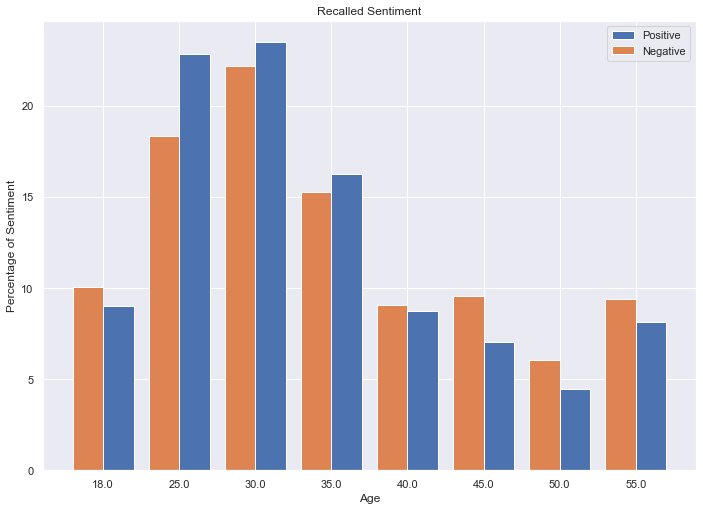

---------- Positive Stats ----------
Age: 18.0 Percentage: 9.019426456984274
Age: 25.0 Percentage: 22.849213691026826
Age: 30.0 Percentage: 23.496762257169287
Age: 35.0 Percentage: 16.23496762257169
Age: 40.0 Percentage: 8.741905642923218
Age: 45.0 Percentage: 7.030527289546716
Age: 50.0 Percentage: 4.4865864939870495
Age: 55.0 Percentage: 8.140610545790935
---------- Negative Stats ----------
Age: 18.0 Percentage: 10.084033613445378
Age: 25.0 Percentage: 18.319327731092436
Age: 30.0 Percentage: 22.18487394957983
Age: 35.0 Percentage: 15.294117647058824
Age: 40.0 Percentage: 9.07563025210084
Age: 45.0 Percentage: 9.57983193277311
Age: 50.0 Percentage: 6.050420168067227
Age: 55.0 Percentage: 9.411764705882353


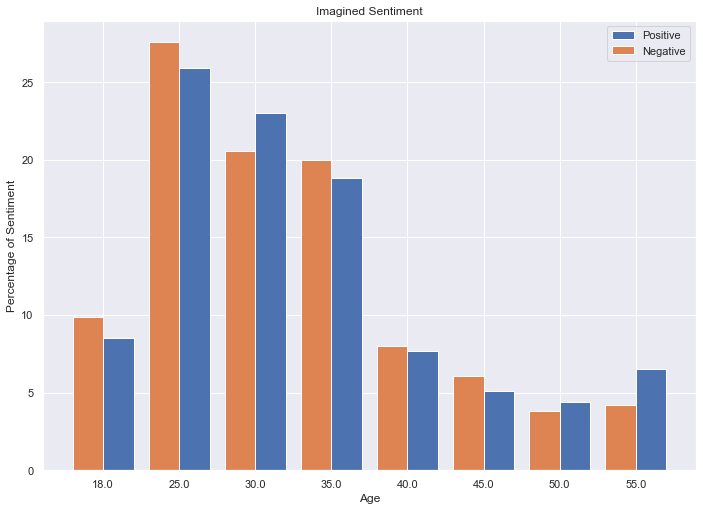

---------- Positive Stats ----------
Age: 18.0 Percentage: 8.540442837776773
Age: 25.0 Percentage: 25.89245368278355
Age: 30.0 Percentage: 23.000451875282423
Age: 35.0 Percentage: 18.84319927699955
Age: 40.0 Percentage: 7.681879801174876
Age: 45.0 Percentage: 5.106190691369182
Age: 50.0 Percentage: 4.428377767736104
Age: 55.0 Percentage: 6.507004066877542
---------- Negative Stats ----------
Age: 18.0 Percentage: 9.885931558935361
Age: 25.0 Percentage: 27.566539923954377
Age: 30.0 Percentage: 20.53231939163498
Age: 35.0 Percentage: 19.96197718631179
Age: 40.0 Percentage: 7.984790874524715
Age: 45.0 Percentage: 6.083650190114068
Age: 50.0 Percentage: 3.802281368821293
Age: 55.0 Percentage: 4.182509505703422


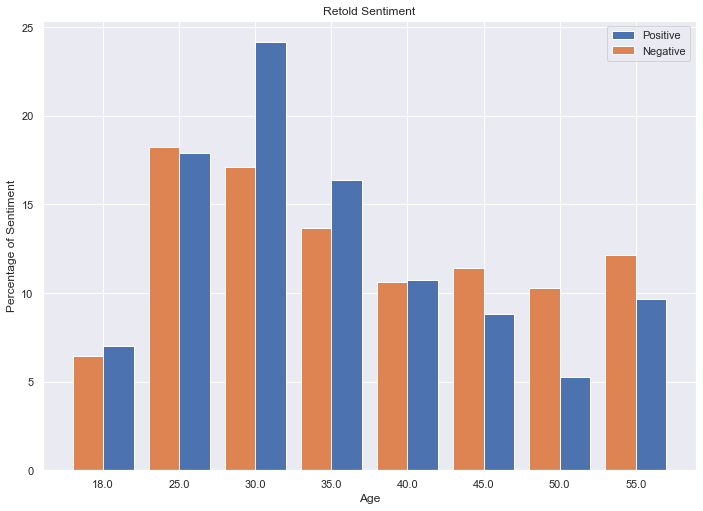

---------- Positive Stats ----------
Age: 18.0 Percentage: 6.999041227229147
Age: 25.0 Percentage: 17.929050814956852
Age: 30.0 Percentage: 24.161073825503358
Age: 35.0 Percentage: 16.39501438159156
Age: 40.0 Percentage: 10.738255033557047
Age: 45.0 Percentage: 8.820709491850431
Age: 50.0 Percentage: 5.273250239693192
Age: 55.0 Percentage: 9.683604985618409
---------- Negative Stats ----------
Age: 18.0 Percentage: 6.4638783269961975
Age: 25.0 Percentage: 18.250950570342205
Age: 30.0 Percentage: 17.110266159695815
Age: 35.0 Percentage: 13.688212927756654
Age: 40.0 Percentage: 10.646387832699618
Age: 45.0 Percentage: 11.406844106463879
Age: 50.0 Percentage: 10.26615969581749
Age: 55.0 Percentage: 12.167300380228136


In [342]:
#Recalled Visualization
X = newRecalled['annotatorAge'].unique()
X.sort()
x_axis = np.arange(len(newRecalled['annotatorAge'].unique()))


# Calculate Positive Amount and Percentages
positive = []
positive_total = 0
for x in X:
    value = len(newRecalled[(newRecalled['annotatorAge'] == x) & (newRecalled['sentiment'] == 'Positive')])
    positive.append(value)
    positive_total+=value

positive_percentage = []
for x in positive:
    positive_percentage.append((x/positive_total) * 100)


# Calculate Negative Amount and Percentages
negative = []
negative_total = 0
for x in X:
    value = len(newRecalled[(newRecalled['annotatorAge'] == x) & (newRecalled['sentiment'] == 'Negative')])
    negative.append(value)
    negative_total+=value

negative_percentage = []
for x in negative:
    negative_percentage.append((x/negative_total) * 100)

plt.xticks(x_axis, X)
plt.bar(x_axis + 0.2 ,positive_percentage,0.4,label='Positive')
plt.bar(x_axis - 0.2 ,negative_percentage,0.4,label='Negative')
plt.ylabel('Percentage of Sentiment')
plt.xlabel('Age')
plt.title('Recalled Sentiment')
plt.legend()
plt.show()

positive_stats = {}
negative_stats = {}
index = 0
for val in X:
    positive_stats[val] = positive_percentage[index]
    negative_stats[val] = negative_percentage[index]
    index+=1
print('---------- Positive Stats ----------')
for i in positive_stats:
    print("Age: {}".format(i) + " Percentage: {}".format(positive_stats[i]))

print('---------- Negative Stats ----------')
for i in negative_stats:
    print("Age: {}".format(i) + " Percentage: {}".format(negative_stats[i]))

#Imagined Visualization
X = newImagined['annotatorAge'].unique()
X.sort()
x_axis = np.arange(len(newImagined['annotatorAge'].unique()))


# Calculate Positive Amount and Percentages
positive = []
positive_total = 0
for x in X:
    value = len(newImagined[(newImagined['annotatorAge'] == x) & (newImagined['sentiment'] == 'Positive')])
    positive.append(value)
    positive_total+=value

positive_percentage = []
for x in positive:
    positive_percentage.append((x/positive_total) * 100)


# Calculate Negative Amount and Percentages
negative = []
negative_total = 0
for x in X:
    value = len(newImagined[(newImagined['annotatorAge'] == x) & (newImagined['sentiment'] == 'Negative')])
    negative.append(value)
    negative_total+=value

negative_percentage = []
for x in negative:
    negative_percentage.append((x/negative_total) * 100)

plt.xticks(x_axis, X)
plt.bar(x_axis + 0.2 ,positive_percentage,0.4,label='Positive')
plt.bar(x_axis - 0.2 ,negative_percentage,0.4,label='Negative')
plt.ylabel('Percentage of Sentiment')
plt.xlabel('Age')
plt.title('Imagined Sentiment')
plt.legend()
plt.show()

positive_stats = {}
negative_stats = {}
index = 0
for val in X:
    positive_stats[val] = positive_percentage[index]
    negative_stats[val] = negative_percentage[index]
    index+=1
print('---------- Positive Stats ----------')
for i in positive_stats:
    print("Age: {}".format(i) + " Percentage: {}".format(positive_stats[i]))

print('---------- Negative Stats ----------')
for i in negative_stats:
    print("Age: {}".format(i) + " Percentage: {}".format(negative_stats[i]))

#Retold Visualization   
X = newRetold['annotatorAge'].unique()
X.sort()
x_axis = np.arange(len(newRetold['annotatorAge'].unique()))


# Calculate Positive Amount and Percentages
positive = []
positive_total = 0
for x in X:
    value = len(newRetold[(newRetold['annotatorAge'] == x) & (newRetold['sentiment'] == 'Positive')])
    positive.append(value)
    positive_total+=value

positive_percentage = []
for x in positive:
    positive_percentage.append((x/positive_total) * 100)


# Calculate Negative Amount and Percentages
negative = []
negative_total = 0
for x in X:
    value = len(newRetold[(newRetold['annotatorAge'] == x) & (newRetold['sentiment'] == 'Negative')])
    negative.append(value)
    negative_total+=value

negative_percentage = []
for x in negative:
    negative_percentage.append((x/negative_total) * 100)

plt.xticks(x_axis, X)
plt.bar(x_axis + 0.2 ,positive_percentage,0.4,label='Positive')
plt.bar(x_axis - 0.2 ,negative_percentage,0.4,label='Negative')
plt.ylabel('Percentage of Sentiment')
plt.xlabel('Age')
plt.title('Retold Sentiment')
plt.legend()
plt.show()

positive_stats = {}
negative_stats = {}
index = 0
for val in X:
    positive_stats[val] = positive_percentage[index]
    negative_stats[val] = negative_percentage[index]
    index+=1
print('---------- Positive Stats ----------')
for i in positive_stats:
    print("Age: {}".format(i) + " Percentage: {}".format(positive_stats[i]))

print('---------- Negative Stats ----------')
for i in negative_stats:
    print("Age: {}".format(i) + " Percentage: {}".format(negative_stats[i]))

##### IVb. Visualization for Recalled, Imagined and Retold by Sentiment and AgeGroup

Text(0.5, 1.0, 'Retold Sentiment')

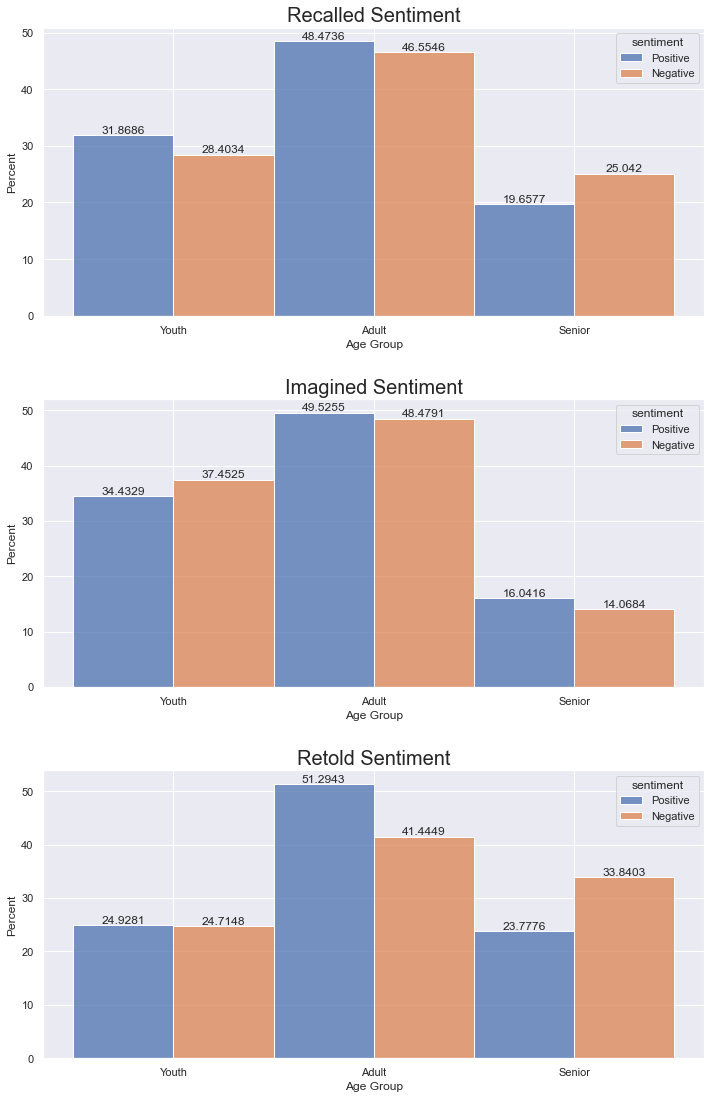

In [343]:
#Plot settings
fig, axes = plt.subplots(3, 1,figsize=(10,15))
fig.tight_layout(h_pad = 5.0)

#Recalled Visualization
graph_2 = sns.histplot(data = newRecalled, x="AgeGroup", hue = 'sentiment', hue_order = ['Positive','Negative'],multiple='dodge', stat = 'percent',common_norm=False,ax=axes[0])
for container in graph_2.containers:
    graph_2.bar_label(container)

graph_2.set(xlabel = 'Age Group')
axes[0].set_title('Recalled Sentiment', fontsize=20)

#Imagined Visualization
graph_2 = sns.histplot(data = newImagined, x="AgeGroup", hue = 'sentiment', hue_order = ['Positive','Negative'],multiple='dodge', stat = 'percent',common_norm=False,ax=axes[1])
for container in graph_2.containers:
    graph_2.bar_label(container)

graph_2.set(xlabel = 'Age Group')
axes[1].set_title('Imagined Sentiment', fontsize=20)

#Retold Visualization
graph_2 = sns.histplot(data = newRetold, x="AgeGroup", hue = 'sentiment', hue_order = ['Positive','Negative'],multiple='dodge', stat = 'percent',common_norm=False,ax=axes[2])
for container in graph_2.containers:
    graph_2.bar_label(container)

graph_2.set(xlabel = 'Age Group')
axes[2].set_title('Retold Sentiment', fontsize=20)

# V. Conclusion and Discussion

In [344]:
#Conclusion